 # Training a GET Model for ATAC-seq Prediction



 This tutorial demonstrates how to train a GET model to predict ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Training without a pretrained checkpoint

 3. Training with a pretrained checkpoint

 4. Comparing the results



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [3]:
#%%
from get_model.config.config import load_config, pretty_print_config
from get_model.run_region import run_zarr as run


Importing from timm.models.layers is deprecated, please import via timm.layers


 ## Configuration



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial.yaml`

In [4]:
#%%
cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg.run.project_name='predict_atac_pbmc' # this is a unique name for this run
cfg.run.run_name='without_pretrain_drop_zero_atpm' # this is a unique name for this run
cfg.dataset.zarr_path = "./pbmc10k_multiome.zarr" # the tutorial data which contains astrocyte atac & rna
cfg.dataset.celltypes = 'cd4_naive' # the celltypes you want to finetune
cfg.dataset.leave_out_chromosomes = 'chr10,chr11'
cfg.run.use_wandb=True # this is a logging system, you can turn it off by setting it to False
cfg.training.epochs = 20 # this is the number of epochs you want to train for
cfg.training.val_check_interval = 1.0 # validation check every epochs; this is for mac because the evaluation step is slow on it somehow...

 ### Switch machine to mac

 One can define machine config in a yaml file, and load it here

In [3]:
# %%
from get_model.config.config import MachineConfig

cfg.machine = MachineConfig(**load_config('machine/mac').machine)
# Note that you can also create a new yaml file replacing the finetune_tutorial.yaml
# or change parameters here directly
cfg.machine.batch_size = 2
pretty_print_config(cfg)

 ### Model Selection



 We'll use the GETRegionFinetuneATAC model, which is designed to use motif information to predict the ATAC values



 This model is particularly useful for understanding the relationship between motifs and chromatin accessibility.

In [3]:
#%%
# Switch model to finetune ATAC model
cfg.model = load_config('model/GETRegionFinetuneATAC').model.model

 ## Training Without Pretraining



 First, let's train the model from scratch (without using a pretrained checkpoint).

 This will give us a baseline for comparison.

In [ ]:
#%%
# first run the model without initializing with a pretrain checkpoint
cfg.finetune.checkpoint = None
trainer = run(cfg)
# atpm_pearson	0.71309
# atpm_r2	0.50965
# atpm_spearman	0.47257

The training speed is almost on par with a 3090 suprisingly...However something in the validation step has not fully utilized the MPS accelarator which make it a bit slow...

In [ ]:
#%%
trainer.callback_metrics


 ## Training With Pretrained Checkpoint



 Now, let's train the model using a pretrained checkpoint. This checkpoint was trained on a large dataset

 and should help the model learn faster and potentially achieve better performance.



 Note: You'll need to download the checkpoint first:

 ```bash

 aws s3 cp s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/pretrain_fetal_adult/checkpoint-799.pth ./checkpoint-799.pth

 ```

In [5]:
#%%
# now train the model with a pretrain checkpoint
cfg.finetune.checkpoint = './checkpoint-799.pth'
cfg.run.run_name = 'with_pretrain_drop_zero_atpm'
cfg.finetune.strict = False # need this because the original checkpoint has a mask-prediction header

In [ ]:
trainer = run(cfg)
trainer.callback_metrics
# atpm_pearson	0.72016
# atpm_r2	0.51364
# atpm_spearman	0.49131

## Results Analysis

Looking at the results, we can see that the pretrained model yields better results than trained from scratch. If you look at the validation loss curve on wandb, you will find that the pretrained version is always lower than the from-scratch version.

This demonstrates the value of transfer learning in genomics - the pretrained model has already learned useful features about the relationship between motifs and chromatin accessibility.

## Interpretation analysis

Let's say we want to examine the contributor to chromatin accessibility at several gene's promoters, the gene list are defined in `cfg.task.gene_list`. You can also set it to `None` to infer all genes.

In [6]:
cfg.task.gene_list

'MYC,SOX10,SOX2,RET'

In [8]:
# Run inference to get the jacobian matrix for genes
# Setup config first. Change state to 'predict'
cfg.stage = 'predict'
cfg.machine.batch_size=1
# resume from the best checkpoint we just traineds
cfg.finetune.checkpoint = None
cfg.finetune.resume_ckpt = trainer.checkpoint_callback.best_model_path#'/Users/xf2217/Downloads/predict_atac_pbmc/with_pretrain_drop_zero_atpm/checkpoints/best.ckpt' #trainer.checkpoint_callback.best_model_path
cfg.run.run_name='interpret'
cfg.dataset.leave_out_celltypes = 'cd4_naive'
# save config to yaml in case we need to resume from it
from omegaconf import OmegaConf
OmegaConf.save(cfg, 'interpret_cfg.yaml')

In [16]:
# run model inference
import os

from get_model.config.config import load_config

if os.path.exists('interpret_cfg.yaml'):
    cfg = load_config('interpret_cfg.yaml', '../../tutorials') # load config from yaml, the path is relative to the get_model/config folder
from get_model.run_region import run_zarr as run

run(cfg)

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


100%|██████████| 1/1 [00:00<00:00, 70.16it/s]


Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/predict_atac_pbmc/with_pretrain_drop_zero_atpm/checkpoints' to '/home/xf2217/output/predict_atac_pbmc/interpret/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/zarr/storage.py:455: UserWarning: an object_codec is only needed for object arrays
  _init_array_metadata(


Saving batch of results to /home/xf2217/output/predict_atac_pbmc/interpret/cd4_naive.zarr


In [10]:
import os

from gcell.cell.celltype import GETHydraCellType

from get_model.config.config import load_config

if os.path.exists('interpret_cfg.yaml'):
    cfg = load_config('interpret_cfg.yaml', '../../tutorials') # load config from yaml, the path is relative to the get_model/config folder
celltype = GETHydraCellType.from_config(cfg, prediction_target='atpm')
celltype

GETHydraCelltype: cd4_naive
        Zarr path: /home/xf2217/output/predict_atac_pbmc/interpret/cd4_naive.zarr
        Number of regions per sample: 200
        Number of features: 283
        Number of genes: 4
        Number of peaks: 800
        

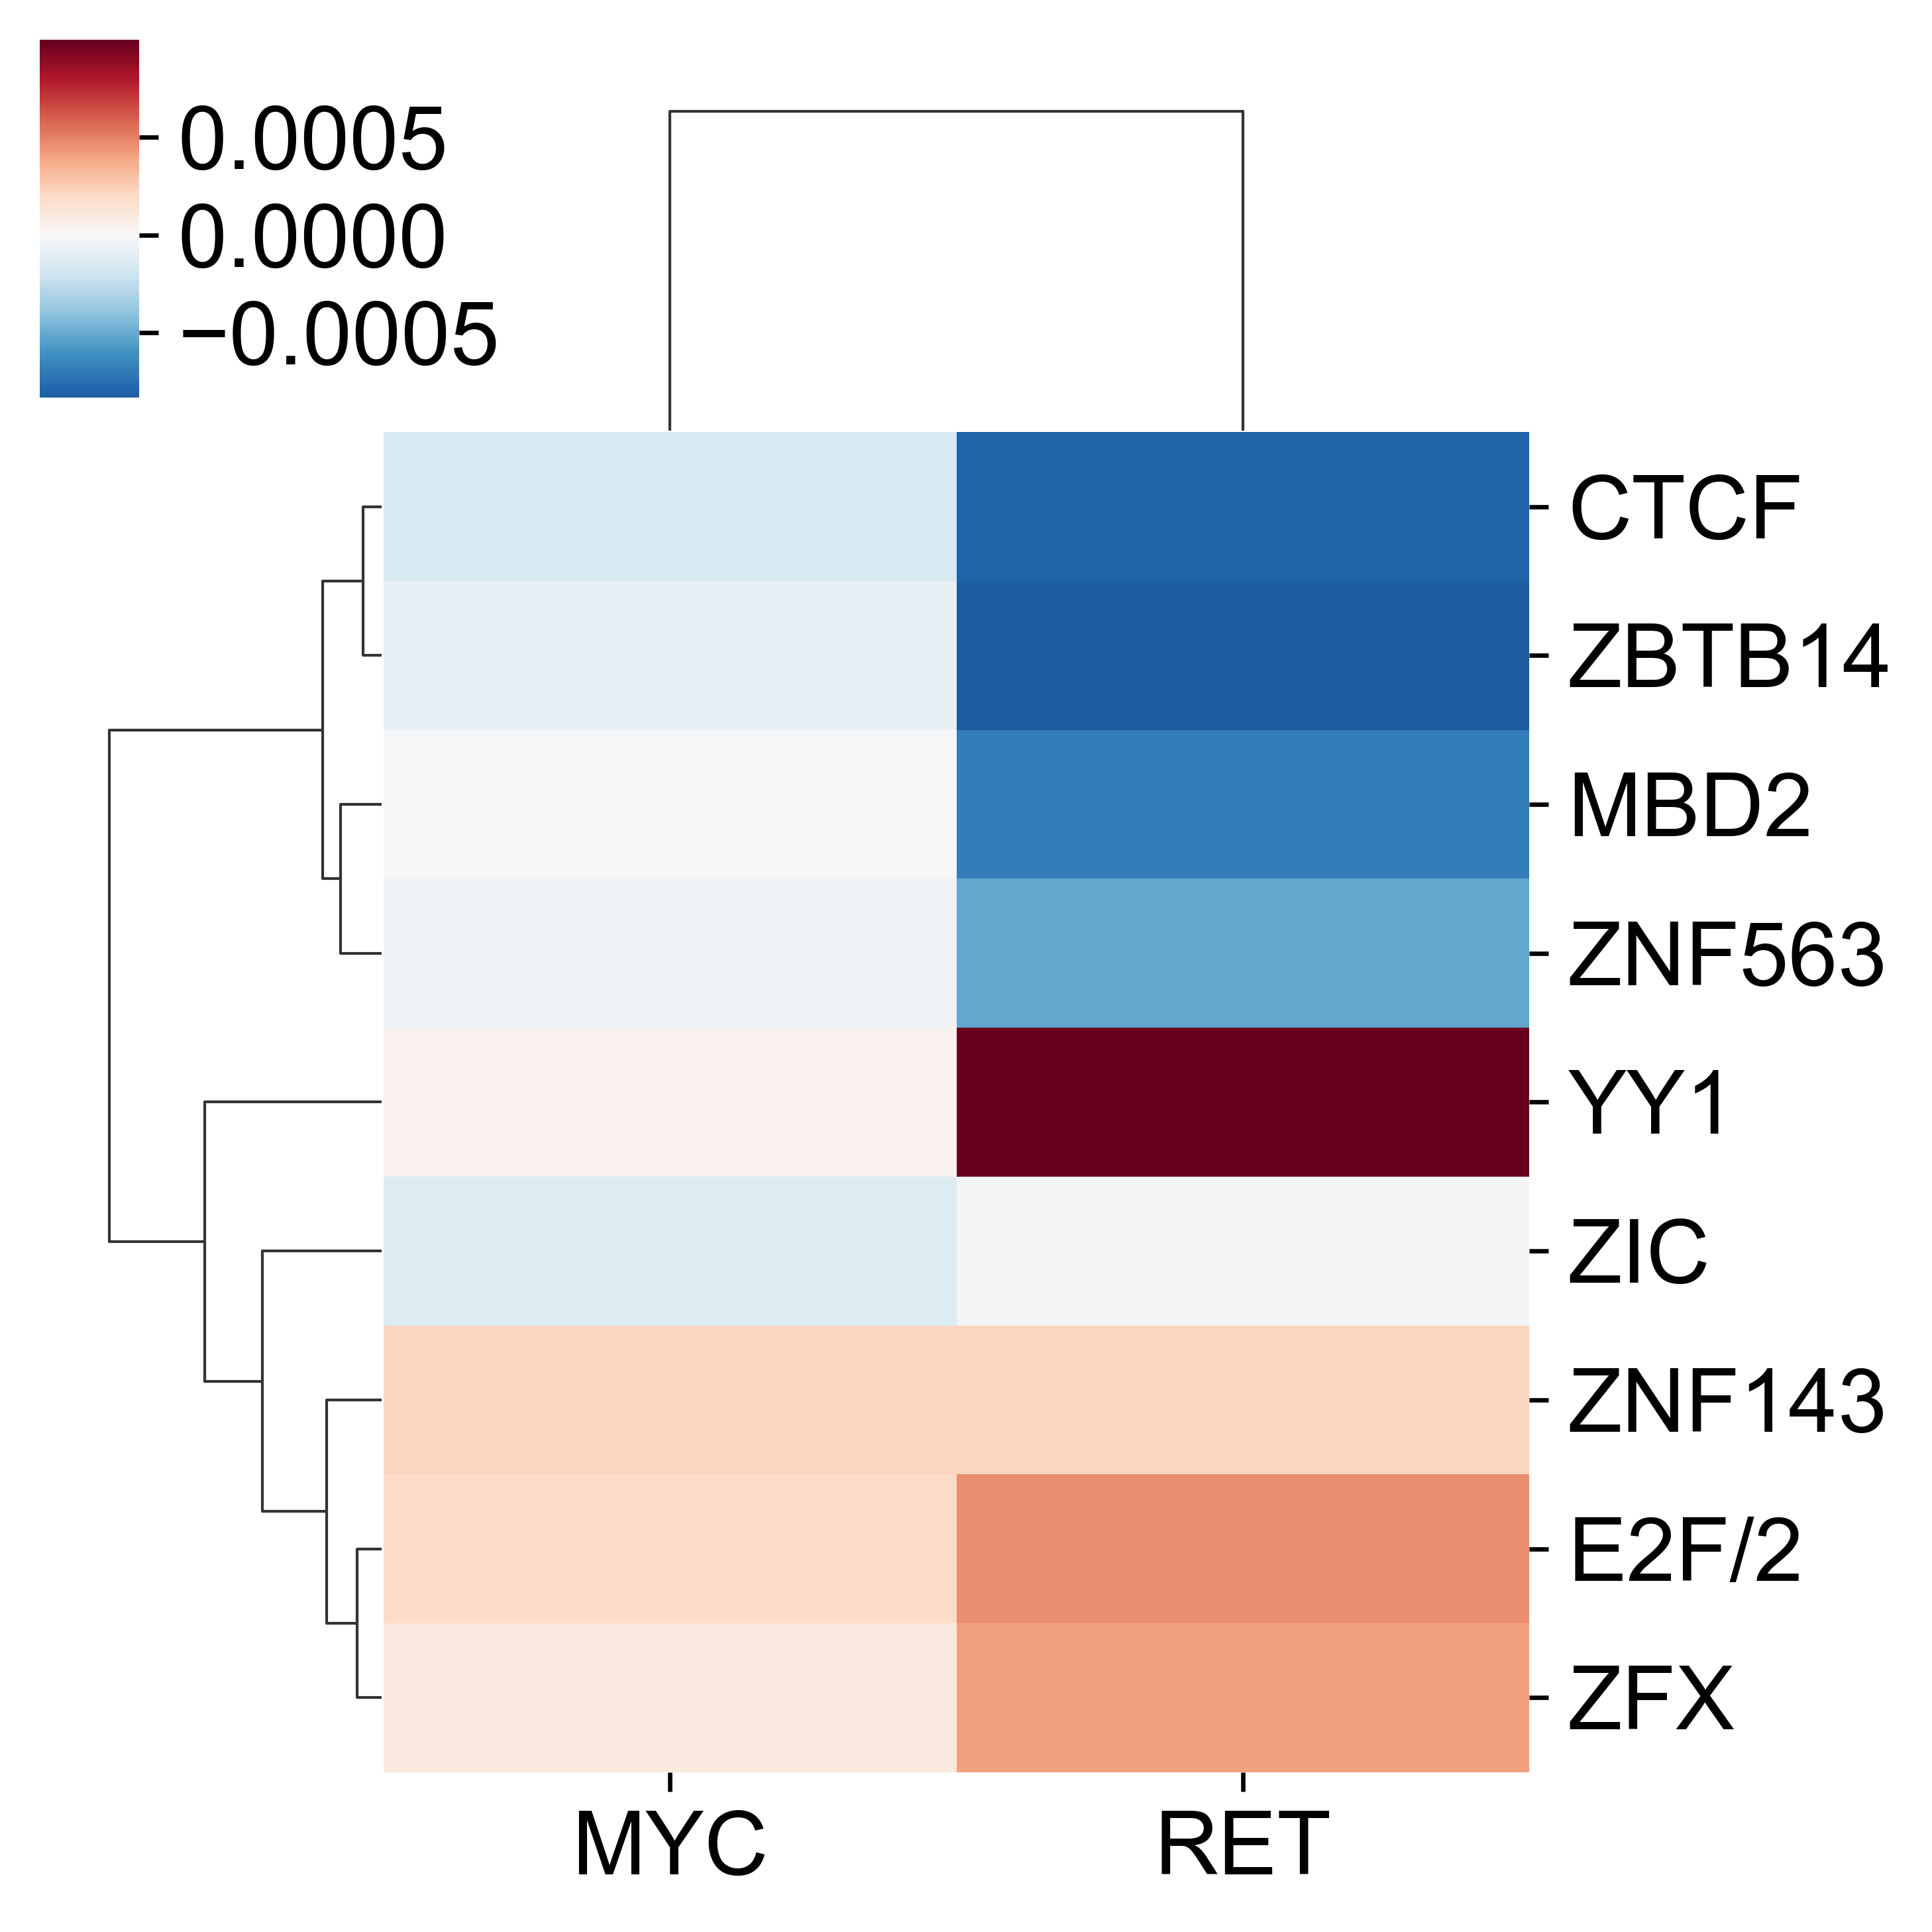

In [11]:
import numpy as np
import seaborn as sns

d = celltype.gene_by_motif.data.T
top_idx_for_each_column = []
for i in range(d.shape[1]):
    top_idx_for_each_column.append(d.iloc[:,i].abs().sort_values(ascending=False).index[:5])
top_idx_for_each_column = np.unique(top_idx_for_each_column)
sns.clustermap(d.loc[top_idx_for_each_column], center=0, cmap='RdBu_r', figsize=(5,5))

In [12]:
celltype.get_gene_jacobian_summary('MYC', axis='motif').sort_values().tail(10)

PRDM5            0.000445
ZIC              0.000453
CTCF             0.000506
ZFN121           0.000607
NRF1             0.000627
ZFX              0.000634
ZNF143           0.000686
E2F/2            0.000926
ETS/1            0.001149
Accessibility    0.001156
dtype: float32

(<Figure size 6000x1200 with 1 Axes>,
 <Axes: xlabel='Genomic Position on Chromosome 8'>)

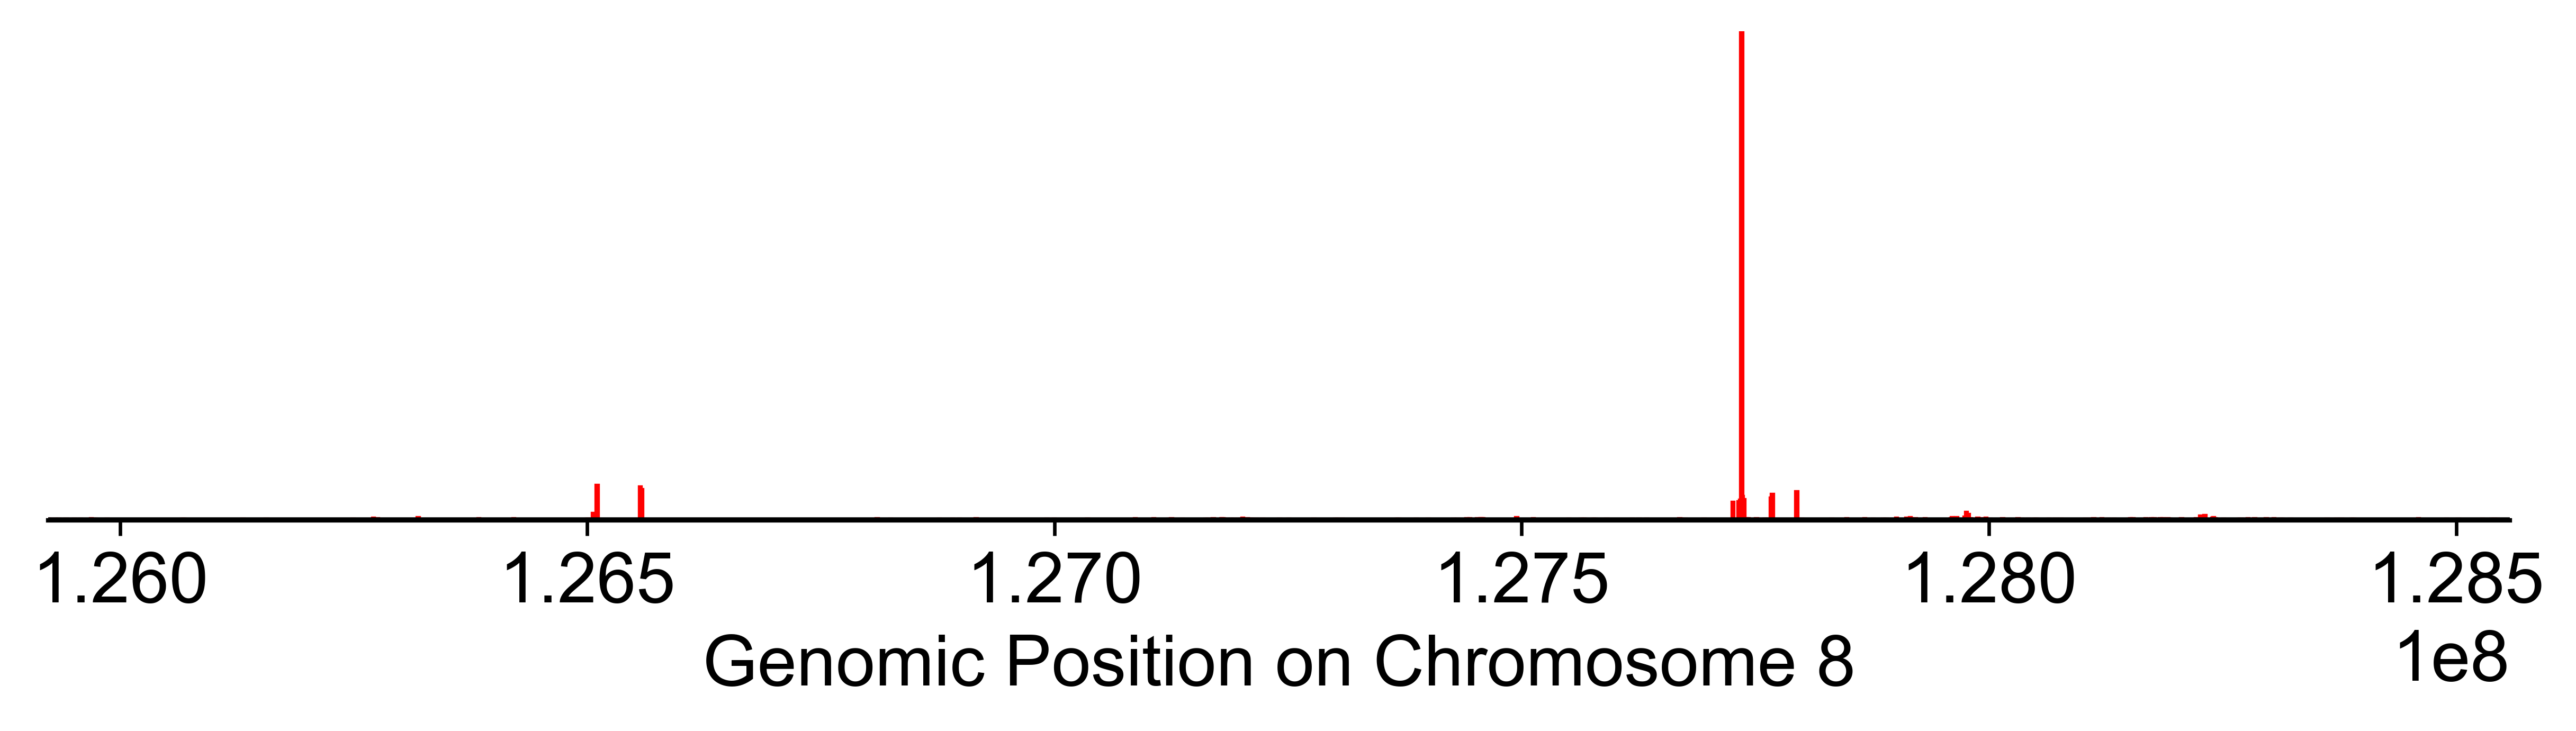

In [13]:
GETHydraCellType.plot_region(celltype.get_gene_jacobian_summary('MYC', axis='region'))

In [14]:
celltype.get_gene_jacobian_summary('MYC', axis='region').sort_values('Score').tail(10)

,index,Chromosome,Start,End,Score
99,99,chr8,127733712,127734544,0.000436
102,102,chr8,127737344,127738248,0.000445
109,109,chr8,127766488,127767392,0.000475
101,101,chr8,127735832,127736536,0.000509
110,110,chr8,127767888,127768608,0.000557
111,111,chr8,127794000,127794888,0.000612
26,26,chr8,126558064,126558880,0.000666
25,25,chr8,126556200,126557112,0.000726
24,24,chr8,126510144,126510968,0.000756
100,100,chr8,127735056,127735704,0.010702


In [22]:
celltype.get_gene_jacobian('RET', multiply_input=True)[0].data[0:200].T.iloc[6:, 100].sort_values()

ZBTB14          -0.161106
MBD2            -0.129857
ZNF563          -0.113342
CTCF            -0.100928
Accessibility   -0.092114
                   ...   
ZFX              0.107399
NRF1             0.110273
E2F/2            0.121392
ETS/1             0.18719
YY1              0.199067
Name: 100, Length: 282, dtype: object